# **Main Determinants of Music Artists Success**
*Tahmid Ahamed & Shiva Menta – FNCE 2370, Professor Michael Roberts*

# Project Code Setup

In [ ]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as ss
from numba import njit
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import tweepy
import datetime
import multiprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [ ]:
# figure formats
font = {'family':'DejaVu Sans',
        'size': 12}
plt.rc('font', **font)

# numpy number precision
np.set_printoptions(precision=4, suppress=True) # display options

TOL = 1.0e-8                                    # Numerical tolerance for comparisons
SEED = 24                                       # Random number seed
SCALE = 12
CPUS = multiprocessing.cpu_count()

# Data Acquisition

**Kworb.net Top Artist Scraping**

*Code Executed to Create Data Set (not executed in current file, imported data set made in separate notebook using this code)*

In [ ]:
# code intentionally not executed
if (0 == 1):
  # url import and beautiful soup setup
  url = "https://kworb.net/spotify/artists.html"
  html = urlopen(url)
  soup = BeautifulSoup(html, 'lxml')


  # import top artists data
  all_tr = soup.find_all("tr")
  list_rows = []
  for tr in all_tr:
      curr_link = ""
      all_links = tr.find_all("a")
      for link in all_links:
          curr_link = link.get("href")

      curr_link = "https://kworb.net/spotify/" + curr_link

      row_dat = tr.find_all('td')
      str_cells = str(row_dat)
      
      cleantext = BeautifulSoup(str_cells, "lxml").get_text()
      cleantext = cleantext.strip("[]")
      dat_arr = cleantext.split(', ')
      dat_arr.append(curr_link)
      list_rows.append(dat_arr)


  # formatting df
  col_names=["Rank","Artist","Total Streams", "Link"]

  kworb_raw = pd.DataFrame(list_rows)
  kworb_raw = kworb_raw.iloc[: , :-2]
  kworb_raw = kworb_raw.iloc[1:]
  kworb_raw.columns = col_names
  kworb_total = kworb_raw


  # adding individual song data to new df
  kworb_agg = pd.DataFrame()

  for index, row in kworb_total.iterrows():
      link = row[3]

      try:
        song_df = pd.read_html(link)[0]
      except:
        continue

      song_df = song_df.iloc[: , :3]

      song_df["Artist"] = row["Artist"]
      song_df["Total Streams"] = row["Total Streams"]
      song_df["Rank"] = row["Rank"]

      kworb_agg = kworb_agg.append(song_df)

*Kworb Data Import*

In [ ]:
df_agg = pd.read_csv('kworb_total.csv')

**Spotify Song Data Sourcing**

*Code Executed to Create Data Set (not executed in current file, imported data set made in separate notebook using this code)*

*Spotify Data Import*

In [ ]:
df_spot = pd.read_csv('spot_data.csv')
df_spot = df_spot.drop(columns=['Unnamed: 0', 'type', 'id', 'uri', 'track_href', 'analysis_url'])

**Tweet Frequency Data Sourcing**

*Twitter API Authentication*

In [ ]:
# code intentionally not executed
if (0 == 1):
  # twitter v1.1 api information
  api_key = "y2EO8nqNHZpGVMy7H2i9SUUSX"
  api_secrets = "H18iD1QIzv4sI98TsRKdsZQthePLESRpD6tCIFzd5IX9YKmVLe"
  access_token = "1025200377405296640-hFe7nhLBoxL74nuvMXtFUF80BlW7Ho"
  access_secret = "249UXqz5n1YO1S39GoYsKE1f3ZiuQWIhHfAICHvF54Io8"
  
  # authenticate to twitter using tweepy v1.1
  auth = tweepy.OAuthHandler(api_key,api_secrets)
  auth.set_access_token(access_token,access_secret)
  
  api = tweepy.API(auth)
  
  try:
      api.verify_credentials()
      print('Successful Authentication')
  except:
      print('Failed authentication')

  # authenticate to twitter using tweepy v2
  bearer_token = "AAAAAAAAAAAAAAAAAAAAAFxCjwEAAAAAPNtYtAkh0zPWmixcZ01yLUe9Dm0%3DmEBScTJzwzO0XxGYmkajTwAKcjNYjdhOBAWmAr7xqLq3yvcTNK"

  client = tweepy.Client(bearer_token=bearer_token)

*Twitter Username Searches and Total Tweets / Account Creation Sourcing*

In [ ]:
# code intentionally not executed
if (0 == 1):
  # get list of artist to conduct username searches
  artists = df_agg["Artist"].unique()

  # creating dataframe for twitter data
  df_twit = pd.DataFrame()

  # data sourcing loop (segmented due to API retrieval limits)
  list_twit_rows = []

  for i in range(0, len(artists)):
    user_arr = api.search_users(q=artists[i], count="1")
    if (len(user_arr) != 0):
      user_info = client.get_user(username=user_arr[0].screen_name, user_fields=["created_at", "public_metrics"])

      created_at = user_info.data.created_at
      follower_count = user_info.data.public_metrics['followers_count']
      tweet_count = user_info.data.public_metrics['tweet_count']

      row = [artists[i], user_arr[0].screen_name, created_at, follower_count, tweet_count]
      list_twit_rows.append(row)

In [ ]:
# import pre-created twitter data
df_twt = pd.read_csv('twitter_data.csv')

**Time-Based Genre Popularity Data Sourcing**

In [ ]:
# import pre-sourced time data
df_genre = pd.read_excel('genre_popularity_time.xlsx')
df_genre = df_genre.fillna(0)

# adjust cells to reflect major genre (0 for < 0.10, 1 for >= 0.10)
def major_classifier(x):
  float_val = float(x)
  if float_val >= 0.10:
    return 1
  else:
    return 0

df_genre.loc[:, df_genre.columns != 'Primary Genre'] = df_genre.loc[:, df_genre.columns != 'Primary Genre'].applymap(major_classifier)

# Data Ingestion and Verification

**Kworb.net Variable / Feature Dictionary**

*Peak Date* – Date when a song's popularity peaked (measured in most streams per day) – Current Type: Object, Intended Type: Datetime

*Title* – Song title – Current Type: Object, Intended Type: String

*Streams* – Total streams for a given song on Spotify – Current Type: Integer, Intended Type: Integer

*Artist* – Artist's name / stage name – Current Type: Object, Intended Type: String

*Total Streams* – Sum of streams for all recorded songs for an artist on Spotify  – Current Type: Integer, Intended Type: Integer

*Rank* – Numerical ranking of an artist in Top 10,000 artists by total streams

In [ ]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147581 entries, 0 to 147580
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     147581 non-null  int64 
 1   Peak Date      147581 non-null  object
 2   Title          147560 non-null  object
 3   Streams        147581 non-null  int64 
 4   Artist         147558 non-null  object
 5   Total Streams  147581 non-null  object
 6   Rank           147581 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.9+ MB


**Spotify API Features Variable / Feature Dictionary**

*Artist Name* – Artist's name / stage name – Current Type: Object, Intended Type: String

*Track Name* – Song title – Current Type: String, Intended Type: String

*collabs* – Number of collaborators present on song (including main artist) – Current Type: Integer, Intended Type: Integer

*danceability* – (0 - 1) scale measuring a song's suitability for dancing based on various musical elements; 0 = not danceable and 1 = danceable – Current Type: Object, Intended Type: Float

*energy* – (0 - 1) scale measuring a song's intensity and activity; 0 = low energy and 1 = high energy – Current Type: Float, Intended Type: Float

*key* – estimated overall key of track, integers map to pitches using pitch class notation – Current Type: Float, Intended Type: Category

*loudness* – overall loundess of a track measured in decibels, averaged across entire track – Current Type: Float, Intended Type: Float

*mode* – key modality of a track; 0 = minor key and 1 = major key – Current Type: Float, Intended Type: Category

*speechiness* – (0 - 1) scale measuring a song's presence of spoken words; 0 = minimal spoken word and 1 = maximal spoken word – Current Type: Float, Intended Type: Float

*acousticness* – (0 - 1) scale measuring a song's acousticness levels – Current Type: Float, Intended Type: Float

*instrumentalness* – (0 - 1) scale measuring a song's level of instrumentalness (opposite of vocality); 0 = minimal instrumental focus and 1 = maximal instrumental focus – Current Type: Float, Intended Type: Float

*liveness* – (0 - 1) scale measuring a song's likeliness of being performed live; 0 = no probability track was performed live and 1 = absolute certainty track was performed live – Current Type: Float, Intended Type: Float

*valence* – (0 - 1) scale measuring a song's level of musical positiveness; 0 = minimal positivity and 1 = maximal positivity – Current Type: Float, Intended Type: Float

*tempo* – overall estimated tempo / speed of a song measured in BPM – Current Type: Float, Intended Type: Float

*duration_ms* – length of a song measured in milliseconds – Current Type: Float, Intended Type: Float

*time_signature* – estimated overall time signature of a track, measured in beats per bar – Current Type: Float, Intended Type: Categorical

*genre* – array of strings representing the minute subgenres in which an artist produces – Current Type: Object, Intended Type: String

In [ ]:
df_spot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159433 entries, 0 to 159432
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Artist Name       159433 non-null  object 
 1   Track Name        159432 non-null  object 
 2   collabs           159433 non-null  int64  
 3   danceability      159433 non-null  object 
 4   energy            159297 non-null  float64
 5   key               159297 non-null  float64
 6   loudness          159297 non-null  float64
 7   mode              159297 non-null  float64
 8   speechiness       159297 non-null  float64
 9   acousticness      159297 non-null  float64
 10  instrumentalness  159297 non-null  float64
 11  liveness          159297 non-null  float64
 12  valence           159297 non-null  float64
 13  tempo             159297 non-null  float64
 14  duration_ms       159297 non-null  float64
 15  time_signature    159297 non-null  float64
 16  genre             15

In [ ]:
vlist = [c for c in df_spot.columns]
df_spot[vlist].describe().T.style.format("{:,.2f}")

,count,mean,std,min,25%,50%,75%,max
collabs,"159,433.00",1.77,1.79,1.00,1.00,1.00,2.00,50.00
energy,"159,297.00",0.62,0.21,0.00,0.49,0.65,0.78,1.00
key,"159,297.00",5.32,3.60,0.00,2.00,6.00,8.00,11.00
loudness,"159,297.00",-7.84,4.53,-60.00,-9.18,-6.84,-5.14,3.94
mode,"159,297.00",0.57,0.49,0.00,0.00,1.00,1.00,1.00
speechiness,"159,297.00",0.12,0.12,0.00,0.04,0.06,0.15,0.97
acousticness,"159,297.00",0.30,0.29,0.00,0.05,0.20,0.50,1.00
instrumentalness,"159,297.00",0.09,0.25,0.00,0.00,0.00,0.00,1.00
liveness,"159,297.00",0.18,0.15,0.00,0.10,0.12,0.22,1.00
valence,"159,297.00",0.52,0.24,0.00,0.33,0.52,0.71,1.00


**Twitter API Variable / Feature Dictionary**

*Artist* – Artist's name / stage name – Current Type: Object, Intended Type: String

*Twitter Handle* – Twitter account username used to access relevant information – Current Type: Object, Intended Type: String

*Twitter Acct. Creation Date* – Date a Twitter account was created – Current Type: Object, Intended Type: Datetime

*Num. Followers* – Total number of followers a Twitter account has (most recently updated 11/28/22) – Current Type: Integer, Intended Type: Integer

*Num Tweets* – Total number of tweets a Twitter account has made (including retweets) since account creation – Current Type: Integer, Intended Type: Integer

In [ ]:
df_twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9421 entries, 0 to 9420
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   9421 non-null   int64 
 1   Artist                       9420 non-null   object
 2   Twitter Handle               9419 non-null   object
 3   Twitter Acct. Creation Date  9421 non-null   object
 4   Num. Followers               9421 non-null   int64 
 5   Num Tweets                   9421 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 441.7+ KB


**Genre Time Data Variable / Feature Dictionary**

*Primary Genre* – Broad music category / genre measured over time – Current Type: Object, Intended Type: String

*Years 1958 - 2022* – 0 or 1 value depending on if a genre is considered as "major" for a certain year, in which 0 corresponds with < 0.10 and 1 corresponds with >= 0.10 of top 100 Billboard chart in a certain year – Current Type: Integer, Intended Type: Integer

In [ ]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Primary Genre  16 non-null     object
 1   1958           16 non-null     int64 
 2   1959           16 non-null     int64 
 3   1960           16 non-null     int64 
 4   1961           16 non-null     int64 
 5   1962           16 non-null     int64 
 6   1963           16 non-null     int64 
 7   1964           16 non-null     int64 
 8   1965           16 non-null     int64 
 9   1966           16 non-null     int64 
 10  1967           16 non-null     int64 
 11  1968           16 non-null     int64 
 12  1969           16 non-null     int64 
 13  1970           16 non-null     int64 
 14  1971           16 non-null     int64 
 15  1972           16 non-null     int64 
 16  1973           16 non-null     int64 
 17  1974           16 non-null     int64 
 18  1975           16 non-null     i

# Feature Engineering and Data Cleaning

**Initial Data Cleaning**

*Kworb.net Dataset*

In [ ]:
# rename columns
df_agg.columns = df_agg.columns.str.strip().str.lower()
df_agg = df_agg.rename(columns={'title': 'song_title', 'streams': 'song_streams', 
  'total streams': 'artist_streams', 'peak date': 'peak_date'})

# formatting artist name and track name to improve merge results
df_agg['artist'] = df_agg['artist'].str.replace('[^\w\s]','')
df_agg['artist'] = df_agg['artist'].str.lower()

df_agg['song_title'] = df_agg['song_title'].str.replace('[^\w\s]','')
df_agg['song_title'] = df_agg['song_title'].str.lower()

# drop unusable columns
df_agg = df_agg.drop(columns={'unnamed: 0', 'rank'})

# drop unusable rows
df_agg = df_agg.loc[df_agg['artist'].notna() & df_agg['song_title'].notna()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


*Spotify Dataset*

In [ ]:
# rename columns
df_spot.columns = df_spot.columns.str.strip().str.lower()
df_spot = df_spot.rename(columns={'track name': 'song_title', 'artist name': 'artist'})

# clean artist and track data
df_spot['artist'] = df_spot['artist'].str.replace('[^\w\s]','')
df_spot['artist'] = df_spot['artist'].str.lower()
df_spot['song_title'] = df_spot['song_title'].str.replace('[^\w\s]','')
df_spot['song_title'] = df_spot['song_title'].str.lower()

# drop data not retrieved from API
df_spot = df_spot.dropna()

# remove columns
df_spot = df_spot.drop(columns=['key', 'time_signature'])

# column type adjustments
df_spot = df_spot.astype({'danceability': 'float'})

# remove any potential duplicates
df_spot = df_spot.drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# dealing with genre data
# removing any slots with no genre
df_spot_compr = df_spot.groupby('artist')['genre'].agg(pd.Series.mode)
df_spot_compr = pd.DataFrame(df_spot_compr)

def map_to_genre_div(x):
  genre_str = x[1:-1]
  if (type(genre_str) == str):
    genre_list = genre_str.split(', ')

    if (len(genre_list) == 0):
      return 1
    else:
      return len(genre_list)
  else:
    return 1

def map_to_dominant_genre(x):
  if (type(x) == str):
    if 'pop' in x:
      return 'pop'
    elif 'hip hop' in x or 'rap' in x or 'trap' in x:
      return 'rap/hip-hop'
    elif 'country' in x:
      return 'country'
    elif 'edm' in x or 'house' in x or 'trance' in x:
      return 'edm'
    elif 'r&b' in x:
      return 'r&b'
    elif 'rock' in x:
      return 'rock'
    else:
      return 'misc'
  else:
    return 'misc'

df_spot_compr['genre_div'] = df_spot_compr['genre'].apply(map_to_genre_div)
df_spot_compr['genre_dom'] = df_spot_compr['genre'].apply(map_to_dominant_genre)
df_spot_compr = df_spot_compr.drop(columns=['genre'])

*Twitter Dataset*

In [ ]:
# rename columns
df_twt.columns = df_twt.columns.str.strip().str.lower()
df_twt = df_twt.rename(columns={'twitter handle': 'twt_handle', 
  'twitter acct. creation date': 'twt_create', 'num. followers': 'twt_follow', 
  'num tweets': 'twt_count'})

# clean artist data
df_twt['artist'] = df_twt['artist'].str.replace('[^\w\s]','')
df_twt['artist'] = df_twt['artist'].str.lower()

# fill twitter count data with 0 (corresponding with no tweets / followers) if NA
df_twt['twt_follow'] = df_twt['twt_follow'].fillna(0)
df_twt['twt_count'] = df_twt['twt_count'].fillna(0)

# drop unusable columns
df_twt = df_twt.drop(columns=['unnamed: 0'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


**Feature Engineering (by dataset)**

*Kworb.net Dataset*

avg_streams – measured as average number of Spotify streams / listens for a song across all of an artist's available discography present in data

In [ ]:
# create dataframe with artist names
df_artists = pd.DataFrame(df_agg['artist'].unique())
artist_cols = ['artist']
df_artists.columns = artist_cols

# calculate average streams per artist using groupby
df_avg_stream = df_agg.groupby('artist')['song_streams'].mean()
avg_stream_cols = ['avg_streams']
df_avg_stream = pd.DataFrame(df_avg_stream)
df_avg_stream.columns = avg_stream_cols

# merging back and creating new dataframe
df_agg_clean = pd.merge(df_artists, df_avg_stream, on='artist')

*Spotify Dataset*

avg_collab – measured as average number of collaborators on each of an artist's songs across entire discography

song_features – various song-specific features (0 - 1 scale mostly) averaged out across all songs in dataset

In [ ]:
# drop unnecessary columns
df_spot = df_spot.drop(columns=['song_title', 'genre'])

# convert duration_ms to minutes
df_spot['duration_min'] = df_spot['duration_ms'] / 60000
df_spot = df_spot.drop(columns=['duration_ms']) 

# calculate means
df_spot['collabs'] = df_spot['collabs'] - 1
df_spot = df_spot.groupby('artist').mean()

# rename columns
df_spot = df_spot.rename(columns={'collabs': 'avg_collab', 'danceability': 'avg_dance', 
  'energy': 'avg_energy', 'loudness': 'avg_loud', 'speechiness': 'avg_spch', 'acousticness': 'avg_acoust',
  'instrumentalness': 'avg_instr', 'liveness': 'avg_live', 'valence': 'avg_val', 'tempo': 'avg_temp',
  'duration_min': 'avg_dur', 'mode': 'avg_mode'})

df_spot_clean = df_spot

Dominant genre and genre diversity metric was previously calculated above, will be included in merge down below.

*Twitter Dataset*

twt_freq – measured as number of tweets on average per week over existence of account

In [ ]:
# convert twt_create to datetime
df_twt['twt_create'] = pd.to_datetime(df_twt['twt_create'])

# create diff_weeks column
today = datetime.datetime(2022, 11, 28)
df_twt['current_date'] = today
df_twt['twt_create'] = df_twt['twt_create'].dt.tz_localize(None)
df_twt['diff_weeks'] = np.trunc((df_twt['current_date'] - df_twt['twt_create']) / np.timedelta64(1, 'W'))

# create twt_freq variable
df_twt['twt_freq'] = df_twt['twt_count'] / df_twt['diff_weeks']
df_twt = df_twt.drop(columns=['twt_handle', 'twt_create', 'twt_follow', 'twt_count', 'current_date', 'diff_weeks'])

# merging back and creating new dataframe
df_twt_clean = pd.merge(df_artists, df_twt, on='artist')

**Merge Datasets**

In [ ]:
df_clean = pd.merge(df_agg_clean, df_twt_clean, on='artist')
df_clean = pd.merge(df_clean, df_spot_compr, on='artist')
df_clean = pd.merge(df_clean, df_spot_clean, on='artist')

df_clean = df_clean.drop(columns=['artist'])

**Post-Feature Engineering Data Cleaning**

In [ ]:
df_clean = (
    df_clean
    .assign(genre_dom=lambda x: x.genre_dom.astype('category'))
)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6683 entries, 0 to 6682
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   avg_streams  6683 non-null   float64 
 1   twt_freq     6683 non-null   float64 
 2   genre_div    6683 non-null   int64   
 3   genre_dom    6683 non-null   category
 4   avg_collab   6683 non-null   float64 
 5   avg_dance    6683 non-null   float64 
 6   avg_energy   6683 non-null   float64 
 7   avg_loud     6683 non-null   float64 
 8   avg_mode     6683 non-null   float64 
 9   avg_spch     6683 non-null   float64 
 10  avg_acoust   6683 non-null   float64 
 11  avg_instr    6683 non-null   float64 
 12  avg_live     6683 non-null   float64 
 13  avg_val      6683 non-null   float64 
 14  avg_temp     6683 non-null   float64 
 15  avg_dur      6683 non-null   float64 
dtypes: category(1), float64(14), int64(1)
memory usage: 842.2 KB


In [ ]:
vlist = [c for c in df_clean.columns]
df_clean[vlist].describe().T.style.format("{:,.2f}")

,count,mean,std,min,25%,50%,75%,max
avg_streams,"6,683.00","15,073,761.43","32,522,431.76","75,992.62","1,957,225.23","5,432,757.00","14,304,296.80","630,732,589.00"
twt_freq,"6,683.00",inf,nan,0.00,1.54,7.58,23.33,inf
genre_div,"6,683.00",2.32,1.66,1.00,1.00,2.00,3.00,14.00
avg_collab,"6,683.00",0.76,0.71,0.00,0.30,0.59,1.00,8.37
avg_dance,"6,683.00",0.65,0.09,0.32,0.59,0.65,0.71,0.89
avg_energy,"6,683.00",0.62,0.11,0.12,0.55,0.63,0.69,0.95
avg_loud,"6,683.00",-7.83,2.22,-21.05,-8.93,-7.56,-6.37,-0.22
avg_mode,"6,683.00",0.57,0.18,0.00,0.45,0.58,0.70,1.00
avg_spch,"6,683.00",0.12,0.07,0.03,0.07,0.10,0.15,0.71
avg_acoust,"6,683.00",0.30,0.15,0.00,0.20,0.29,0.39,0.98


*Invalid Values*

We can see above that twt_freq has some invalid values, likely caused by a division by zero. We'll clear that below by setting twt_freq as 0 for those values.

In [ ]:
df_clean['twt_freq'].replace([np. inf, -np. inf], 0, inplace=True)

*Outliers*

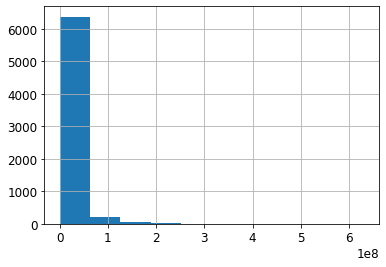

In [ ]:
df_clean['avg_streams'].hist()

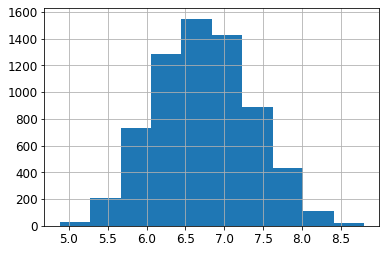

In [ ]:
df_clean['avg_streams'] = np.log10(df_clean['avg_streams'])
df_clean['avg_streams'].hist()

**Train-Test Split**

In [ ]:
train_size = 0.8
df_train = df_clean.sample(frac=train_size, random_state=SEED)
train_idx = df_train.index
df_test = df_clean.loc[~(df_clean.index.isin(train_idx))]

In [ ]:
# creating column list
cat_list = [c for c in df_clean.columns if (c == 'genre_dom')]
num_list = [c for c in df_clean.columns if (c != 'genre_dom')]

*Float Variables*

Sample Mean Equality

In [ ]:
mu=df_clean[num_list].mean()
se=df_clean[num_list].std()/np.sqrt(len(df_clean))

mu_train=df_train[num_list].mean()
se_train=df_train[num_list].std()/np.sqrt(len(df_train))

mu_test=df_test[num_list].mean()
se_test=df_test[num_list].std()/np.sqrt(len(df_test))

t_train=(mu - mu_train) / np.sqrt(se**2 + se_train**2)
t_test=(mu - mu_test) / np.sqrt(se**2 + se_test**2)

x = pd.concat((mu,mu_train,mu_test,t_train,t_test),
          axis=1,
          keys=['avg-full','avg-train','avg-test','t_train','t_test']
         )

# test for significance

x.style.format("{:.2f}")

,avg-full,avg-train,avg-test,t_train,t_test
avg_streams,6.74,6.74,6.72,-0.40,0.96
twt_freq,22.44,22.18,23.48,0.29,-0.54
genre_div,2.32,2.32,2.33,0.04,-0.09
avg_collab,0.76,0.77,0.74,-0.41,1.03
avg_dance,0.65,0.65,0.65,0.08,-0.19
avg_energy,0.62,0.62,0.62,0.15,-0.37
avg_loud,-7.83,-7.84,-7.79,0.24,-0.58
avg_mode,0.57,0.57,0.57,-0.05,0.13
avg_spch,0.12,0.12,0.11,-0.24,0.59
avg_acoust,0.30,0.30,0.30,-0.12,0.30


Kolmogorov-Smirnov Test

In [ ]:
ks_dict = {}
for n in num_list:
    ks = ss.kstest(df_clean[n],df_train[n])
    ks_dict[n] = ks[1]
    assert ks_dict[n] > 0.10

ks_dict

{'avg_streams': 0.9999981987877041,
 'twt_freq': 0.9999999999137305,
 'genre_div': 1.0,
 'avg_collab': 0.9999122205893802,
 'avg_dance': 0.9999996644472402,
 'avg_energy': 0.9999999999156131,
 'avg_loud': 0.9999997453268482,
 'avg_mode': 0.9999999970252141,
 'avg_spch': 0.9987642221021911,
 'avg_acoust': 0.9999999999995034,
 'avg_instr': 0.9999999982940398,
 'avg_live': 0.999999999236956,
 'avg_val': 0.9999999997242792,
 'avg_temp': 0.999999999983924,
 'avg_dur': 0.9999999999385549}

*Categorical Variable (Genre)*

Chi2 p-values in parentheses


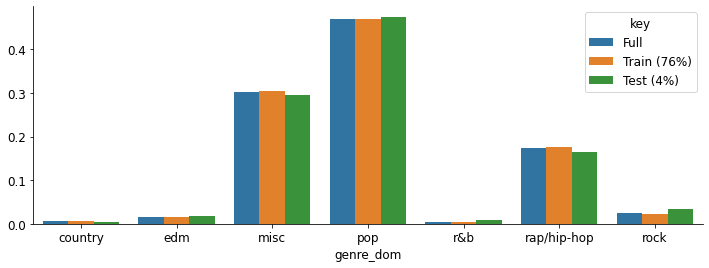

In [ ]:
fig,axes=plt.subplots(len(cat_list),1,figsize=(12,len(cat_list)*4))
axes=np.ravel(axes)
for c,ax in zip(cat_list,axes):
    eperc=df_clean[c].value_counts(normalize=True)

    # train test
    etrain=(eperc*df_train.shape[0]).sort_index()
    atrain=df_train[c].value_counts().sort_index()
    chi2train=ss.chisquare(f_obs=atrain,f_exp=etrain)

    # test test
    etest=(eperc*df_test.shape[0]).sort_index()
    atest=df_test[c].value_counts().sort_index()
    chi2test=ss.chisquare(f_obs=atest,f_exp=etest)

    eperc=eperc.to_frame().assign(key='Full')
    trainperc=(atrain/atrain.sum()).to_frame().assign(key=f'Train ({chi2train.pvalue:.0%})')
    testperc=(atest/atest.sum()).to_frame().assign(key=f'Test ({chi2test.pvalue:.0%})')
    z = pd.concat((eperc,trainperc,testperc),axis=0).reset_index()

    sns.barplot(x='index', y=c, hue='key', data=z,ax=ax)
    ax.set_xlabel(c)
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

print("Chi2 p-values in parentheses")

# Exploratory Data Analysis

Our EDA will be guided by our main goal: determining the features that are the most relevant to the success of an artist. However, another thing we'll be looking for in our EDA is understanding how these features vary across genre. Although this isn't something we'll be direclty observing for this model, we know that the communities between genres have different aggregate characteristics.

**Dependent Variable**

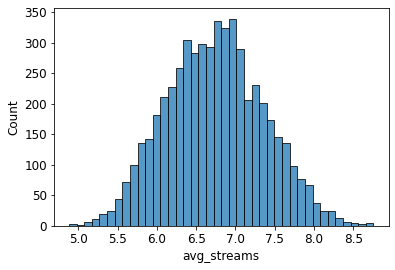

In [ ]:
sns.histplot(df_train.avg_streams)

**Numerical Values**

In [ ]:
df_train.describe([.01,.5,.99]).T

,count,mean,std,min,1%,50%,99%,max
avg_streams,5346.0,6.739945,0.618534,4.880771,5.421353e+00,6.741251,8.176578,8.757404
twt_freq,5346.0,22.177461,46.745056,0.000000,0.000000e+00,7.429592,217.746747,1004.119332
genre_div,5346.0,2.319865,1.649845,1.000000,1.000000e+00,2.000000,8.000000,14.000000
avg_collab,5346.0,0.769074,0.719173,0.000000,0.000000e+00,0.600000,3.334605,8.368421
avg_dance,5346.0,0.646748,0.085952,0.315235,4.384468e-01,0.649946,0.828105,0.895000
avg_energy,5346.0,0.619536,0.108194,0.124208,3.271582e-01,0.625805,0.853755,0.948583
avg_loud,5346.0,-7.837360,2.224947,-21.048900,-1.476125e+01,-7.561136,-3.708716,-0.216150
avg_mode,5346.0,0.574428,0.181463,0.000000,1.500000e-01,0.578947,0.950000,1.000000
avg_spch,5346.0,0.116422,0.065811,0.028140,3.378842e-02,0.101752,0.328793,0.708785
avg_acoust,5346.0,0.303777,0.149557,0.000689,4.775450e-02,0.284820,0.747999,0.979739


**Categorical Variables**

In [ ]:
def create_barplot(data,col):
    x = data[col].value_counts(normalize=True).sort_index()
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    ax=sns.barplot(x=x.index,y=x,ax=ax);
    ax.set_xlabel(col)
    ax.set_ylabel("Fraction of observations")

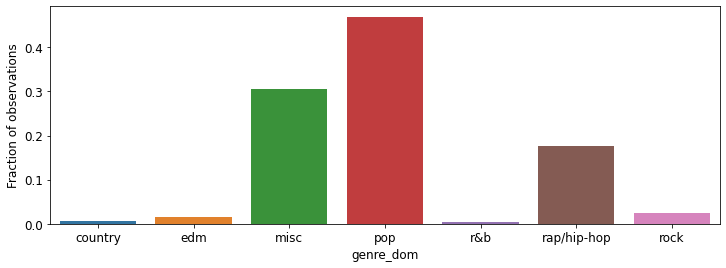

In [ ]:
create_barplot(df_train, 'genre_dom')

**Feature Relationships**

*Feature Correlations*

*Spotify Song Characteristics (Tahmid)*

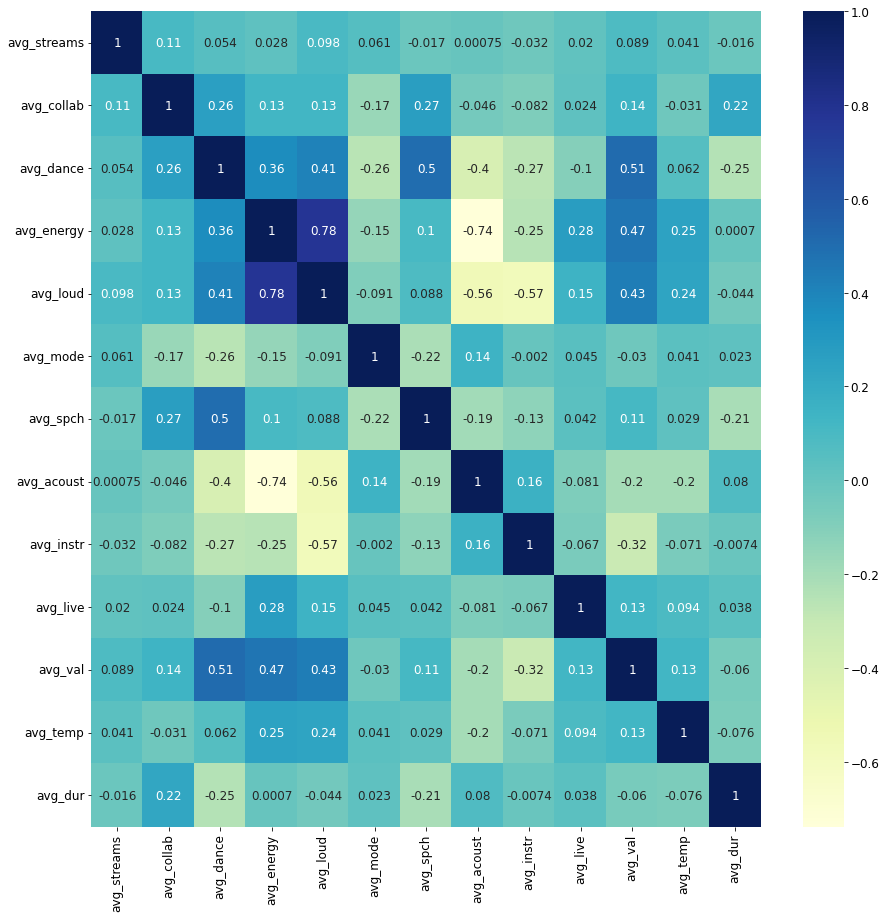

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
spot_feat_corr = sns.heatmap(df_train[['avg_streams', 'avg_collab','avg_dance', 'avg_energy', 'avg_loud', 'avg_mode', 'avg_spch', 'avg_acoust',
          'avg_instr', 'avg_live', 'avg_val', 'avg_temp', 'avg_dur']].corr(), cmap="YlGnBu", annot=True, ax=ax)

plt.show()

Vs. Genres

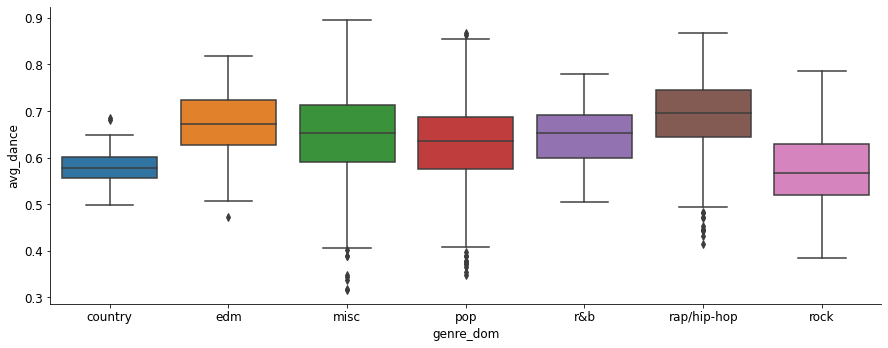

In [ ]:
sns.catplot(x='genre_dom', y='avg_dance', data=df_train, kind='box' ,aspect=2.5 );

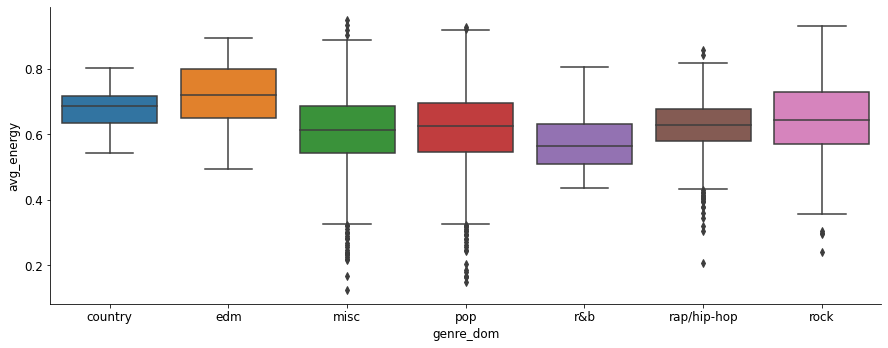

In [ ]:
sns.catplot(x='genre_dom', y='avg_energy', data=df_train, kind='box' ,aspect=2.5 );

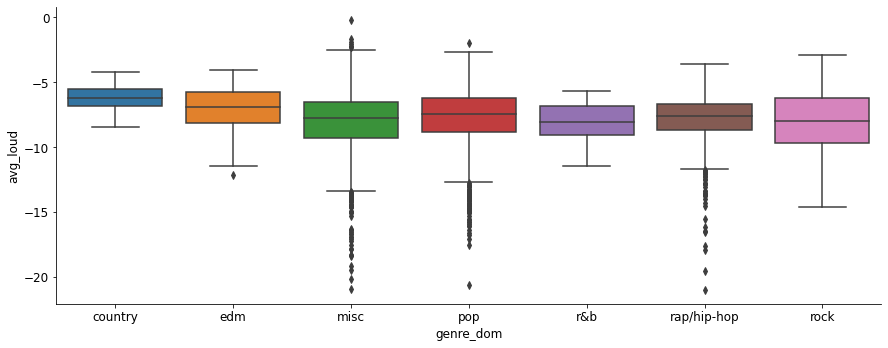

In [ ]:
sns.catplot(x='genre_dom', y='avg_loud', data=df_train, kind='box' ,aspect=2.5 );

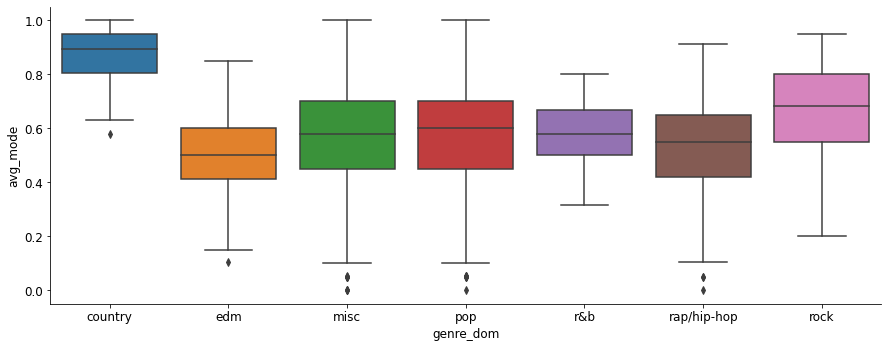

In [ ]:
sns.catplot(x='genre_dom', y='avg_mode', data=df_train, kind='box' ,aspect=2.5 );

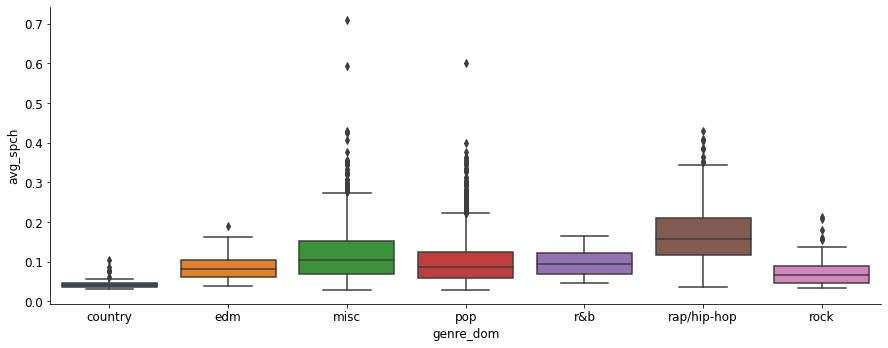

In [ ]:
sns.catplot(x='genre_dom', y='avg_spch', data=df_train, kind='box' ,aspect=2.5 );

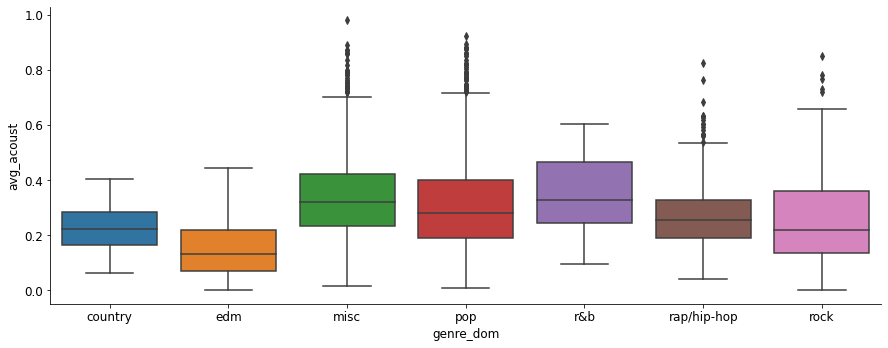

In [ ]:
sns.catplot(x='genre_dom', y='avg_acoust', data=df_train, kind='box' ,aspect=2.5 );

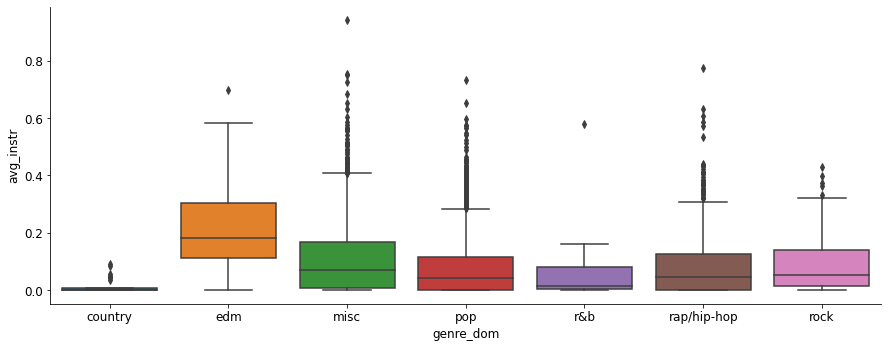

In [ ]:
sns.catplot(x='genre_dom', y='avg_instr', data=df_train, kind='box' ,aspect=2.5 );

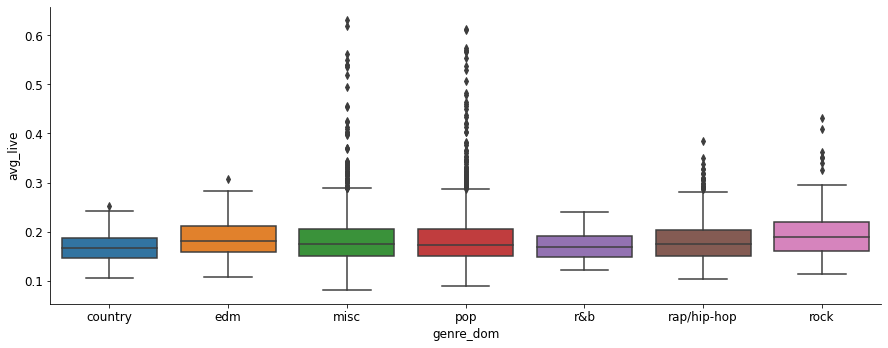

In [ ]:
sns.catplot(x='genre_dom', y='avg_live', data=df_train, kind='box' ,aspect=2.5 );

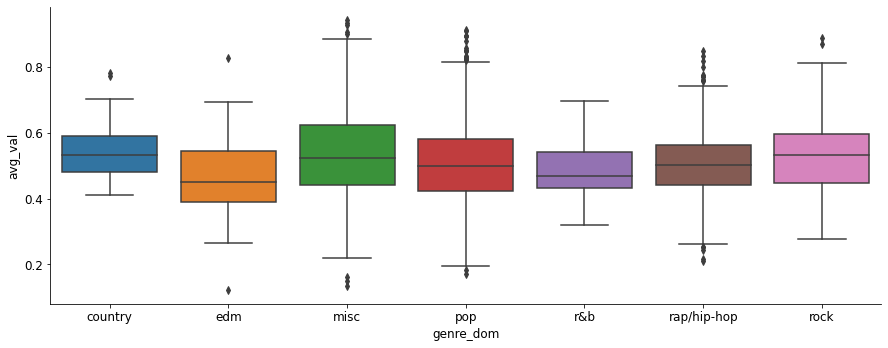

In [ ]:
sns.catplot(x='genre_dom', y='avg_val', data=df_train, kind='box' ,aspect=2.5 );

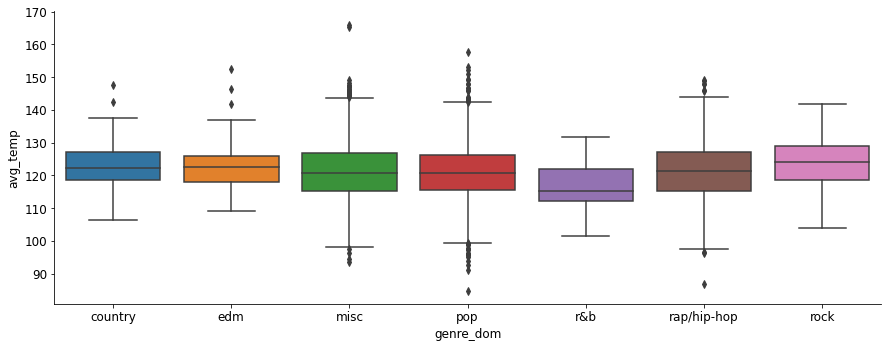

In [ ]:
sns.catplot(x='genre_dom', y='avg_temp', data=df_train, kind='box' ,aspect=2.5 );

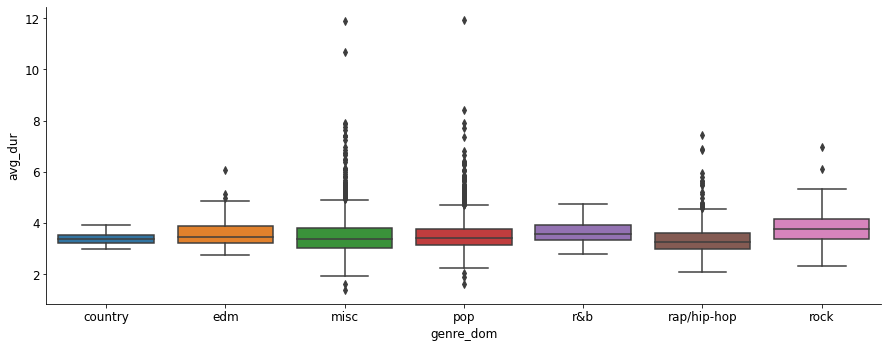

In [ ]:
sns.catplot(x='genre_dom', y='avg_dur', data=df_train, kind='box' ,aspect=2.5 );

*Tweet Frequency / Social Media Activity (Shiva)*

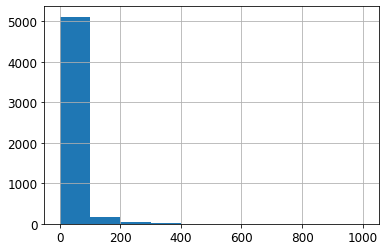

In [ ]:
df_train['twt_freq'].hist()

vs. Artist Popularity

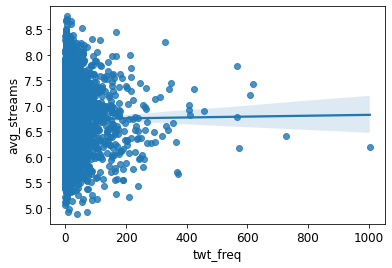

In [ ]:
sns.regplot(x=df_train['twt_freq'],y=df_train['avg_streams'])

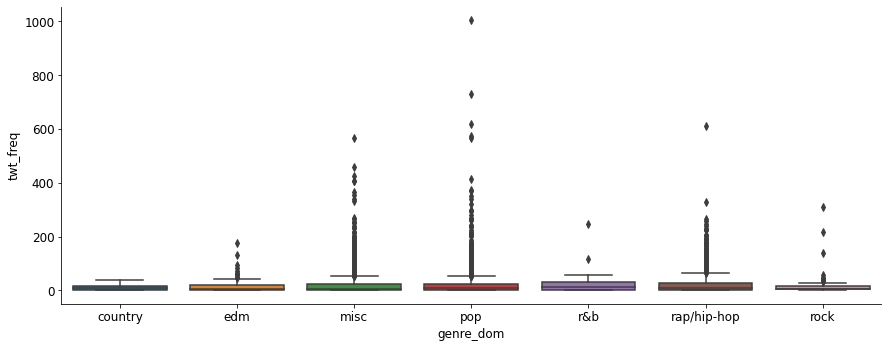

In [ ]:
sns.catplot(x='genre_dom', y='twt_freq', data=df_train, kind='box' ,aspect=2.5 );

*Collaboration Frequency (Tahmid)*

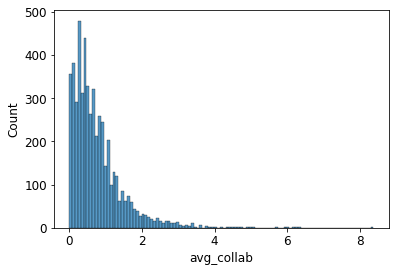

In [ ]:
sns.histplot(df_train.avg_collab)

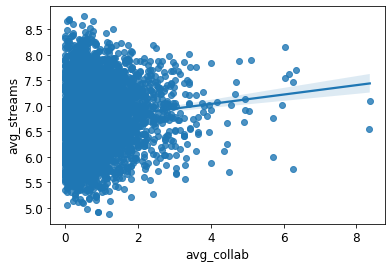

In [ ]:
sns.regplot(x=df_train['avg_collab'],y=df_train['avg_streams'])

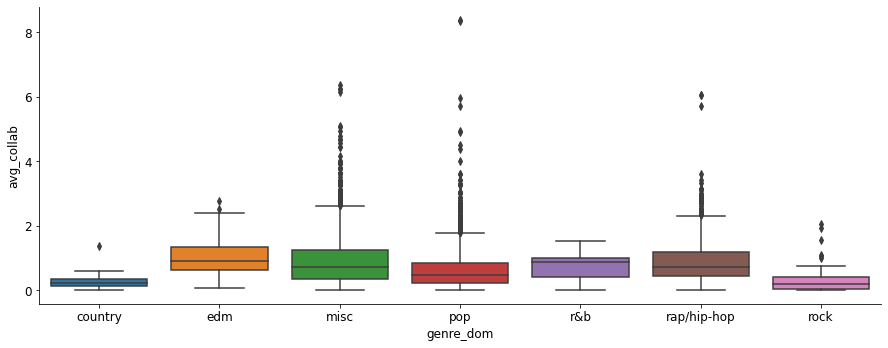

In [ ]:
sns.catplot(x='genre_dom', y='avg_collab', data=df_train, kind='box' ,aspect=2.5 );

*Genre Diversity Metric (Shiva)*

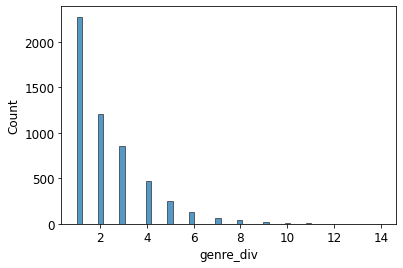

In [ ]:
sns.histplot(df_train.genre_div)

vs. Artist Popularity

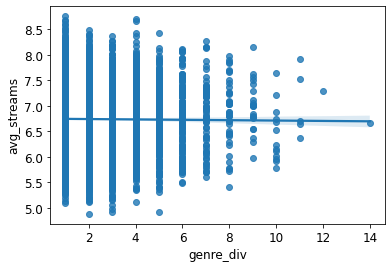

In [ ]:
sns.regplot(x=df_train['genre_div'],y=df_train['avg_streams'])

vs. Genre

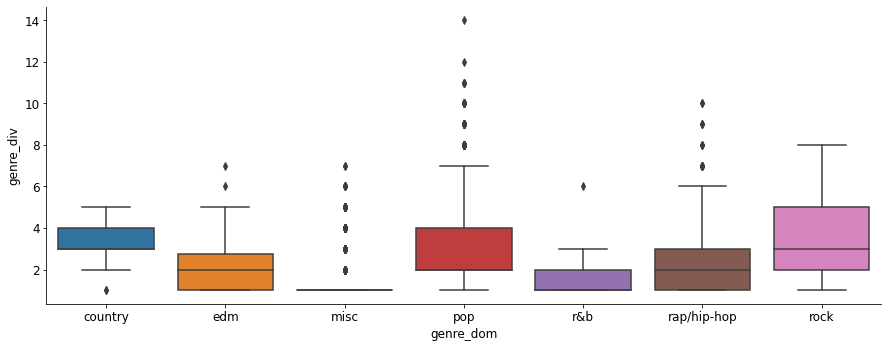

In [ ]:
sns.catplot(x='genre_dom', y='genre_div', data=df_train, kind='box' ,aspect=2.5 );

# Model Development and Analysis

In [ ]:
y_train = df_train[['avg_streams']]
x_train = pd.get_dummies(df_train.drop(['avg_streams'], axis=1))

x_train = sm.add_constant(x_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
y_test = df_test['avg_streams']
x_test = pd.get_dummies(df_train.drop(['avg_streams'], axis = 1))
x_test = sm.add_constant(x_test)


**Linear Regression (Shiva)**

*Execution*

In [ ]:
ols_model = sm.OLS(y_train, x_train)
fit_model = ols_model.fit()

print(fit_model.summary())

                            OLS Regression Results                            
Dep. Variable:            avg_streams   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     24.94
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.39e-88
Time:                        10:11:55   Log-Likelihood:                -4777.6
No. Observations:                5346   AIC:                             9597.
Df Residuals:                    5325   BIC:                             9735.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.72

In [ ]:
lr_model = LinearRegression()
lr_cv = cross_val_score(
    lr_model,
    x_train,
    y_train,
    cv=4,
    scoring='r2',
    n_jobs = CPUS-1
)
print(f"Default model parameters:\n{lr_model.get_params()}")
print(f"Fold scores:\n{lr_cv}")
print(f"Mean score: {lr_cv.mean():.8f}")

Default model parameters:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
Fold scores:
[0.0872 0.0821 0.056  0.0827]
Mean score: 0.07700825


Test RMSE Linear Regression

In [ ]:
lr_model.fit(x_train, y_train)
lr_preds = lr_model.predict(x_test)
lr_rmse = ((((lr_preds - y_test)**2).mean())**(1/2))
lr_rmse

0.5896011469923795

**Lasso Regression (Shiva)**

*Execution*

In [ ]:
lasso_r = Lasso()

In [ ]:
# Keep grid small to run quickly - alpha between 0 and 1
alphas = np.logspace(start=-5,stop=-0.5,num=30,base=10.0)

def lasso_gs(alphas):
    tuned_params = {'alpha': alphas}
    lr_gs = GridSearchCV(lasso_r,
                         param_grid=tuned_params, 
                         scoring='r2',
                         cv=4,
                         refit=False,
                         n_jobs=CPUS-1,
                         verbose=10,
                        ).fit(x_train,y_train)

    return lr_gs
    
lr_gs = lasso_gs(alphas)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4; 1/30] START alpha=1e-05................................................
[CV 1/4; 1/30] END .................alpha=1e-05;, score=0.087 total time=   0.1s
[CV 2/4; 1/30] START alpha=1e-05................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.579e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.616e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/4; 1/30] END .................alpha=1e-05;, score=0.082 total time=   0.1s
[CV 3/4; 1/30] START alpha=1e-05................................................
[CV 3/4; 1/30] END .................alpha=1e-05;, score=0.056 total time=   0.1s
[CV 4/4; 1/30] START alpha=1e-05................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.558e+01, tolerance: 1.534e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/4; 1/30] END .................alpha=1e-05;, score=0.083 total time=   0.1s
[CV 1/4; 2/30] START alpha=1.429461338356844e-05................................
[CV 1/4; 2/30] END .alpha=1.429461338356844e-05;, score=0.087 total time=   0.1s
[CV 2/4; 2/30] START alpha=1.429461338356844e-05................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/4; 2/30] END .alpha=1.429461338356844e-05;, score=0.082 total time=   0.1s
[CV 3/4; 2/30] START alpha=1.429461338356844e-05................................
[CV 3/4; 2/30] END .alpha=1.429461338356844e-05;, score=0.056 total time=   0.1s
[CV 4/4; 2/30] START alpha=1.429461338356844e-05................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.570e+01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e+01, tolerance: 1.534e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/4; 2/30] END .alpha=1.429461338356844e-05;, score=0.083 total time=   0.1s
[CV 1/4; 3/30] START alpha=2.0433597178569438e-05...............................
[CV 1/4; 3/30] END alpha=2.0433597178569438e-05;, score=0.087 total time=   0.1s
[CV 2/4; 3/30] START alpha=2.0433597178569438e-05...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/4; 3/30] END alpha=2.0433597178569438e-05;, score=0.082 total time=   0.1s
[CV 3/4; 3/30] START alpha=2.0433597178569438e-05...............................
[CV 3/4; 3/30] END alpha=2.0433597178569438e-05;, score=0.056 total time=   0.1s
[CV 4/4; 3/30] START alpha=2.0433597178569438e-05...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e+01, tolerance: 1.534e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/4; 3/30] END alpha=2.0433597178569438e-05;, score=0.083 total time=   0.1s
[CV 1/4; 4/30] START alpha=2.92090371703225e-05.................................
[CV 1/4; 4/30] END ..alpha=2.92090371703225e-05;, score=0.087 total time=   0.1s
[CV 2/4; 4/30] START alpha=2.92090371703225e-05.................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.585e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/4; 4/30] END ..alpha=2.92090371703225e-05;, score=0.082 total time=   0.1s
[CV 3/4; 4/30] START alpha=2.92090371703225e-05.................................
[CV 3/4; 4/30] END ..alpha=2.92090371703225e-05;, score=0.056 total time=   0.1s
[CV 4/4; 4/30] START alpha=2.92090371703225e-05.................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.576e+01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+01, tolerance: 1.534e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/4; 4/30] END ..alpha=2.92090371703225e-05;, score=0.082 total time=   0.1s
[CV 1/4; 5/30] START alpha=4.1753189365604006e-05...............................
[CV 1/4; 5/30] END alpha=4.1753189365604006e-05;, score=0.087 total time=   0.1s
[CV 2/4; 5/30] START alpha=4.1753189365604006e-05...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/4; 5/30] END alpha=4.1753189365604006e-05;, score=0.082 total time=   0.1s
[CV 3/4; 5/30] START alpha=4.1753189365604006e-05...............................
[CV 3/4; 5/30] END alpha=4.1753189365604006e-05;, score=0.056 total time=   0.1s
[CV 4/4; 5/30] START alpha=4.1753189365604006e-05...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.066e+00, tolerance: 1.534e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

[CV 4/4; 5/30] END alpha=4.1753189365604006e-05;, score=0.082 total time=   0.1s
[CV 1/4; 6/30] START alpha=5.9684569951223044e-05...............................
[CV 1/4; 6/30] END alpha=5.9684569951223044e-05;, score=0.087 total time=   0.1s
[CV 2/4; 6/30] START alpha=5.9684569951223044e-05...............................
[CV 2/4; 6/30] END alpha=5.9684569951223044e-05;, score=0.083 total time=   0.1s
[CV 3/4; 6/30] START alpha=5.9684569951223044e-05...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+01, tolerance: 1.541e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.348e-01, tolerance: 1.507e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 3/4; 6/30] END alpha=5.9684569951223044e-05;, score=0.057 total time=   0.1s
[CV 4/4; 6/30] START alpha=5.9684569951223044e-05...............................
[CV 4/4; 6/30] END alpha=5.9684569951223044e-05;, score=0.082 total time=   0.1s
[CV 1/4; 7/30] START alpha=8.531678524172815e-05................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.598e+01, tolerance: 1.553e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 1/4; 7/30] END .alpha=8.531678524172815e-05;, score=0.087 total time=   0.1s
[CV 2/4; 7/30] START alpha=8.531678524172815e-05................................
[CV 2/4; 7/30] END .alpha=8.531678524172815e-05;, score=0.083 total time=   0.1s
[CV 3/4; 7/30] START alpha=8.531678524172815e-05................................
[CV 3/4; 7/30] END .alpha=8.531678524172815e-05;, score=0.057 total time=   0.1s
[CV 4/4; 7/30] START alpha=8.531678524172815e-05................................
[CV 4/4; 7/30] END .alpha=8.531678524172815e-05;, score=0.082 total time=   0.1s
[CV 1/4; 8/30] START alpha=0.00012195704601594415...............................
[CV 1/4; 8/30] END alpha=0.00012195704601594415;, score=0.087 total time=   0.1s
[CV 2/4; 8/30] START alpha=0.00012195704601594415...............................
[CV 2/4; 8/30] END alpha=0.00012195704601594415;, score=0.083 total time=   0.1s
[CV 3/4; 8/30] START alpha=0.00012195704601594415...............................
[CV 3/4; 8/30] END alpha=0.0

In [ ]:
print(f"Best parameter: {lr_gs.best_params_['alpha']:.5f} and score {lr_gs.best_score_:.2%}")

Best parameter: 0.00012 and score 7.72%


In [ ]:
opt_lasso = Lasso(**lr_gs.best_params_)
opt_lasso_cv = cross_val_score(
    opt_lasso,
    x_train,
    y_train,
    cv = 4,
    scoring = 'r2',
    n_jobs = CPUS - 1
)
print(f"Default parameters:\n{opt_lasso.get_params()}")
print(f"Fold scores:\n{opt_lasso_cv}")
print(f"Mean score: {opt_lasso_cv.mean():.8f}")

Default parameters:
{'alpha': 0.00012195704601594415, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Fold scores:
[0.0867 0.0831 0.0572 0.0818]
Mean score: 0.07718422


Test RMSE Lasso Regression

In [ ]:
opt_lasso.fit(x_train, y_train)
opt_lasso_preds = opt_lasso.predict(x_test)
opt_lasso_rmse = ((((opt_lasso_preds - y_test)**2).mean())**(1/2))
opt_lasso_rmse

0.5897630636247657

**Random Forest (Tahmid)**

*Execution*

In [ ]:
y_train = df_train['avg_streams']
x_train = pd.get_dummies(df_train.drop(['avg_streams'], axis=1))

y_test = df_test['avg_streams']
x_test = pd.get_dummies(df_test.drop(['avg_streams'], axis = 1))


In [ ]:
rf_model = RandomForestRegressor()

In [ ]:
rf_cv = cross_val_score(rf_model,
                        x_train,
                        y_train,
                        cv=4,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
print(f"Default parameters:\n{rf_model.get_params()}")
print(f"Fold scores:\n{rf_cv}")
print(f"Mean score: {rf_cv.mean():.8f}")

Default parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.1187 0.1309 0.0951 0.0973]
Mean score: 0.11049940


In [ ]:
pgrid = {
    'n_estimators': np.linspace(50,1000,20,dtype=int),
    'max_features': ['auto','sqrt','log2'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,4,8],
}

def random_forest_rs(pgrid,folds):
    rf_rs = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=pgrid,
                               scoring='r2',
                               n_iter=30,
                               cv=folds,
                               verbose=10,
                               n_jobs=CPUS-1,
                               random_state=SEED
                              ).fit(x_train,y_train)
    
    return rf_rs

rf_rs = random_forest_rs(pgrid,4)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4; 1/30] START max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400
[CV 1/4; 1/30] END max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.138 total time=   4.3s
[CV 2/4; 1/30] START max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400
[CV 2/4; 1/30] END max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.134 total time=   3.6s
[CV 3/4; 1/30] START max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400
[CV 3/4; 1/30] END max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.105 total time=   3.7s
[CV 4/4; 1/30] START max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400
[CV 4/4; 1/30] END max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.114 total time=   3.7s
[CV 1/4; 2/30] START max_featu

In [ ]:
opt_rf_model = RandomForestRegressor(**rf_rs.best_params_)
opt_rf_model_cv = cross_val_score(
    opt_rf_model,
    x_train,
    y_train,
    cv=4,
    scoring = 'r2',
    n_jobs = CPUS-1
)
print(f"Default parameters:\n{opt_rf_model.get_params()}")
print(f"Fold scores:\n{opt_rf_model_cv}")
print(f"Mean score: {opt_rf_model_cv.mean():.8f}")

Default parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.1471 0.1438 0.1091 0.1189]
Mean score: 0.12970055


Test RMSE Random Forest

In [ ]:
opt_rf_model.fit(x_train, y_train)
optimal_rf_test_preds = opt_rf_model.predict(x_test)


In [ ]:
rf_rmse = (((optimal_rf_test_preds - y_test)**2).mean())**(1/2)

In [ ]:
rf_rmse

0.5742079473512082

**Gradient Boosting (Tahmid)**

*Execution*

In [ ]:
gb = GradientBoostingRegressor()
gb_cv = cross_val_score(gb,
                        x_train,
                        y_train,
                        cv=4,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
print(f"Default parameters:\n{gb.get_params()}")
print(f"Fold scores:\n{gb_cv}")
print(f"Mean score: {gb_cv.mean():.8f}")

Default parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.12   0.1065 0.0972 0.102 ]
Mean score: 0.10639841


In [ ]:
pgrid = {
    'learning_rate': [0.1,0.05,0.01],
    'n_estimators': [100,200,300],
    'max_depth': [4,6,8],
    'min_samples_leaf': [1,5,10]
}

def gradient_boosting_gs(pgrid, folds):    
    gb_gs = RandomizedSearchCV(estimator=gb,
                               param_distributions=pgrid,
                               scoring='r2',
                               n_iter=30,
                               cv=folds,
                               verbose=10,
                               n_jobs=CPUS-1,
                               random_state=SEED
                              ).fit(x_train,y_train)
     
    return gb_gs

gb_gs = gradient_boosting_gs(pgrid,4)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4; 1/30] START learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100
[CV 1/4; 1/30] END learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100;, score=0.117 total time=   3.6s
[CV 2/4; 1/30] START learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100
[CV 2/4; 1/30] END learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100;, score=0.132 total time=   3.3s
[CV 3/4; 1/30] START learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100
[CV 3/4; 1/30] END learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100;, score=0.090 total time=   3.3s
[CV 4/4; 1/30] START learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100
[CV 4/4; 1/30] END learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=100;, score=0.104 total time=   3.3s
[CV 1/4; 2/30] START learning_rate=0.01, max_depth=6, min_samples_leaf=1, n_estimators

In [ ]:
opt_gb_model = GradientBoostingRegressor(**gb_gs.best_params_)
opt_gb_cv = cross_val_score(
    opt_gb_model,
    x_train, 
    y_train,
    cv=4,
    scoring='r2',
    n_jobs = CPUS-1
)
print(f"Default parameters:\n{opt_gb_model.get_params()}")
print(f"Fold scores:\n{opt_gb_cv}")
print(f"Mean score: {opt_gb_cv.mean():.8f}")

Default parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.1161 0.1271 0.095  0.1141]
Mean score: 0.11309926


Test RMSE Gradient Boosting

In [ ]:
opt_gb_model.fit(x_train, y_train)
optimal_gb_test_preds = opt_gb_model.predict(x_test)

In [ ]:
gb_rmse = (((optimal_gb_test_preds - y_test)**2).mean())**(1/2)

In [ ]:
gb_rmse

0.5822932657014884